# DSC 630 - Predictive Analytics
# Term Project - Summer 2024
# David Berberena | Brian Mann

In [1]:
# imported libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Milestone 3 - Preliminary Analysis

In [3]:
# dataset
url = 'https://www.kaggle.com/datasets/mrsimple07/restaurants-revenue-prediction'

### Step 1: Reading and Describing the Data

In [4]:
df = pd.read_csv('restaurant_revenue.csv')
df.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


In [5]:
df.shape

(1000, 8)

In [21]:
df.isna().sum()

Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64

In [7]:
df.describe()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,53.271000,30.219120,9.958726,29.477085,0.497000,49.837000,268.724172
std,26.364914,11.278760,5.845586,11.471686,0.500241,29.226334,103.982950
min,10.000000,10.009501,0.003768,10.037177,0.000000,0.000000,-28.977809
25%,30.000000,20.396828,4.690724,19.603041,0.000000,24.000000,197.103642
50%,54.000000,30.860614,10.092047,29.251365,0.000000,50.000000,270.213964
75%,74.000000,39.843868,14.992436,39.553220,1.000000,76.000000,343.395793
max,99.000000,49.974140,19.994276,49.900725,1.000000,99.000000,563.381332


### Step 2: Histograms and Bar Charts

In [8]:
def make_histogram(data, col):
    sns.histplot(data[col], color='#f56c42')
    plt.title(f'Histogram of {col}')
    plt.show()

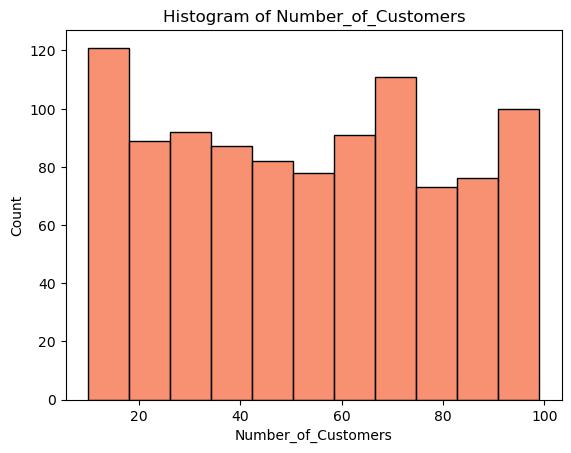

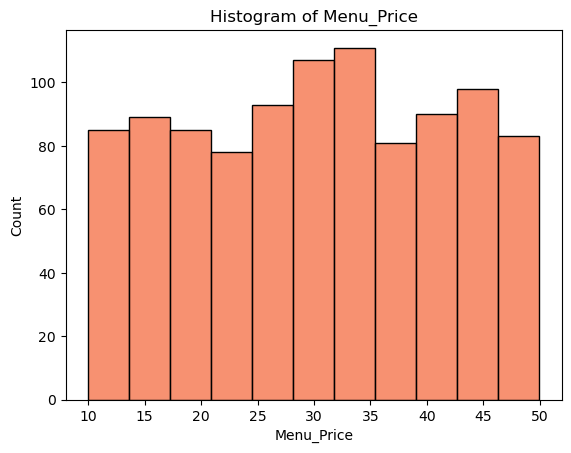

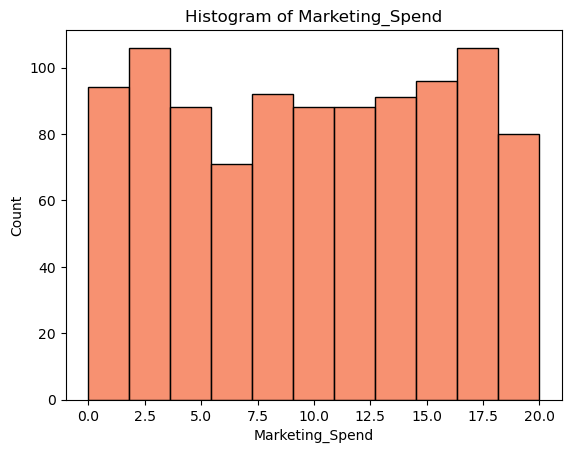

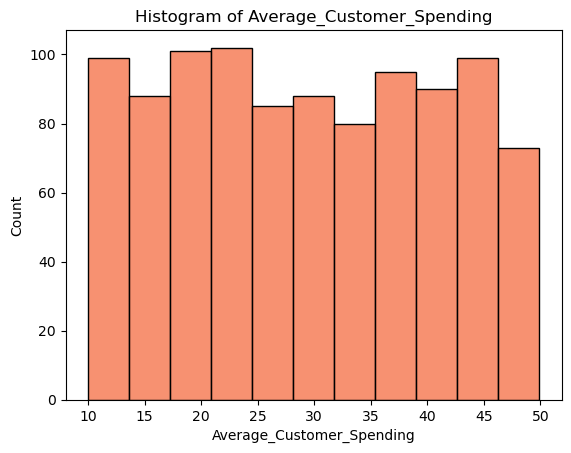

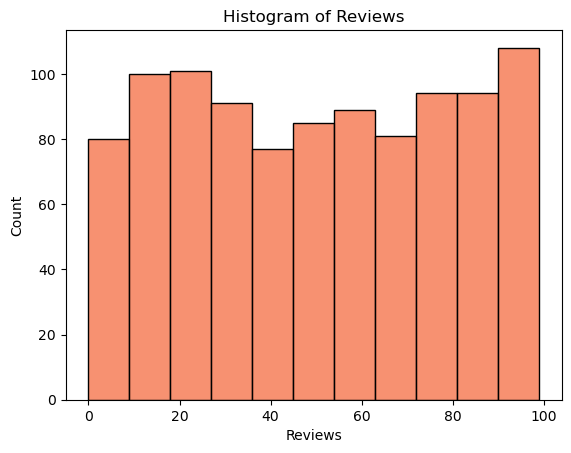

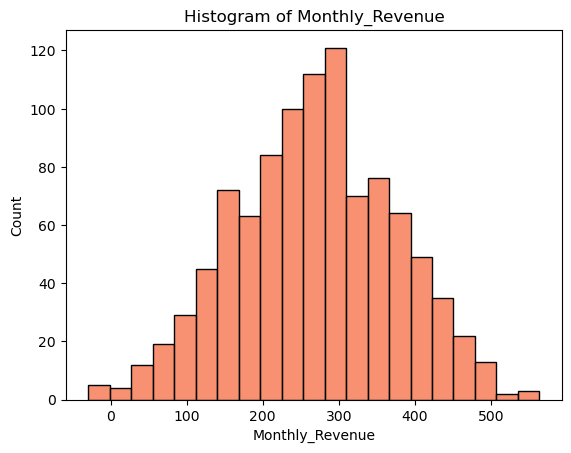

In [9]:
for col in df.describe().drop(columns='Promotions').columns:
    make_histogram(df, col)

In [10]:
def count_bar(data, col):
    counts = data[col].value_counts().reset_index()
    sns.barplot(data=counts, y=col, x='count', orient='h', palette='Set2')
    plt.title(f'Bar Plot of {col}')
    plt.show()

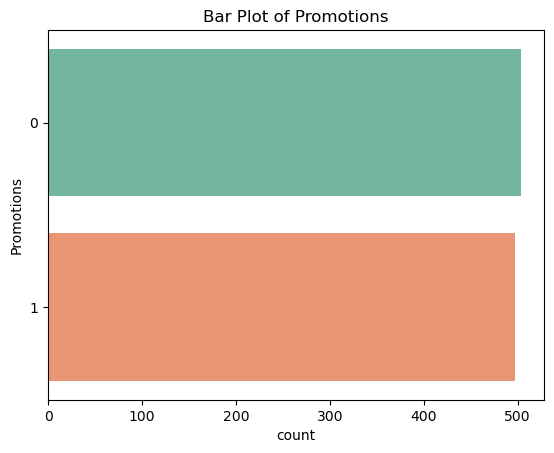

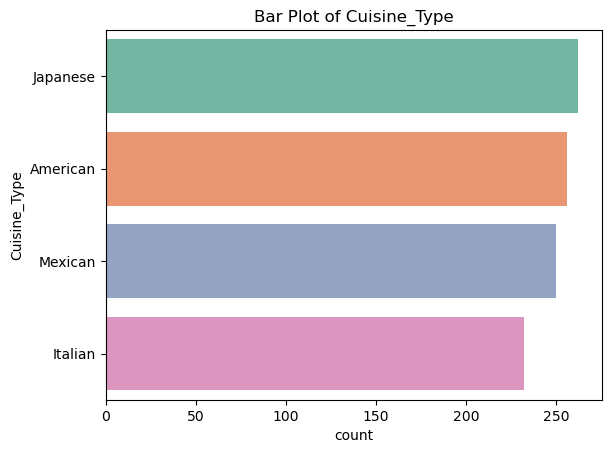

In [11]:
for col in ['Promotions', 'Cuisine_Type']:
    count_bar(df, col)

## Step 3: Correlation and Scatterplots

In [12]:
dum = pd.get_dummies(df, columns=['Cuisine_Type'])
dum.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Cuisine_Type_American,Cuisine_Type_Italian,Cuisine_Type_Japanese,Cuisine_Type_Mexican
0,61,43.117635,12.663793,36.236133,0,45,350.912040,False,False,True,False
1,24,40.020077,4.577892,17.952562,0,36,221.319091,False,True,False,False
2,81,41.981485,4.652911,22.600420,1,91,326.529763,False,False,True,False
3,70,43.005307,4.416053,18.984098,1,59,348.190573,False,True,False,False
4,30,17.456199,3.475052,12.766143,1,30,185.009121,False,True,False,False


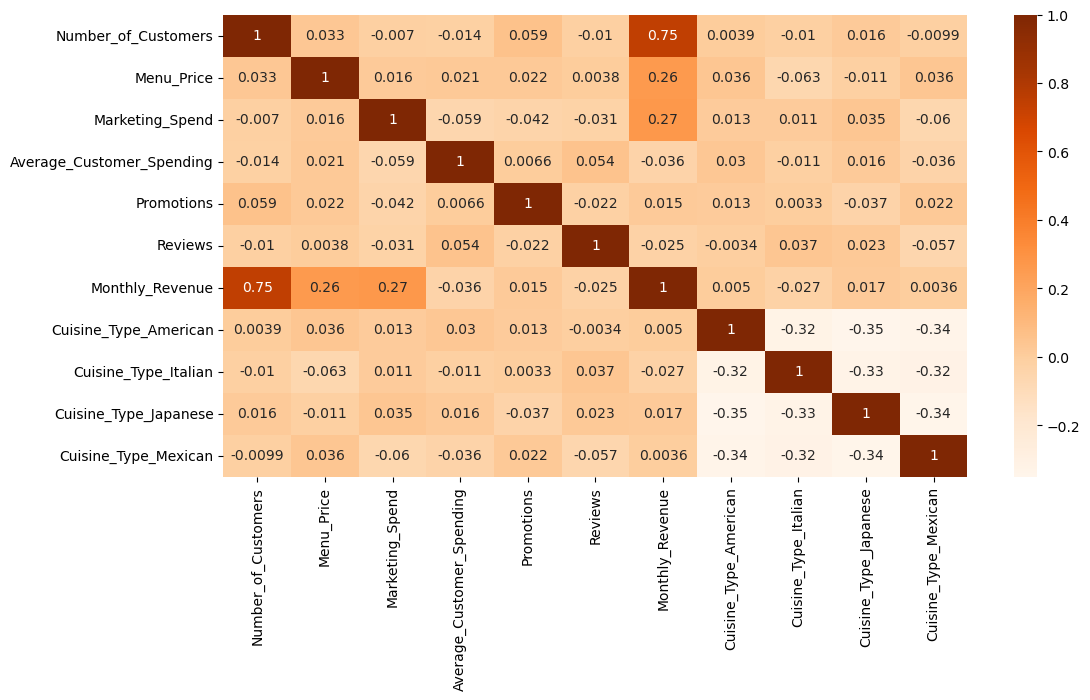

In [13]:
corrs = dum.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corrs, cmap="Oranges", annot=True)
plt.show()

In [14]:
def scatter_with_fit(data, col1, col2):
    sns.lmplot(data=data, x=col1, y=col2, line_kws={'color': 'red'}, 
               scatter_kws={'color': '#79def7', 's': 5})
    plt.title(f'{col1} vs. {col2}')
    plt.show()

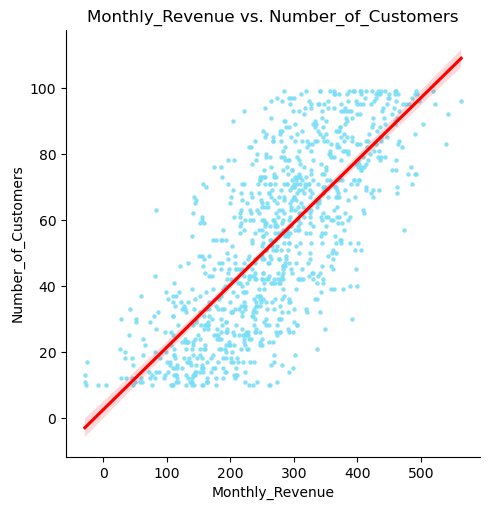

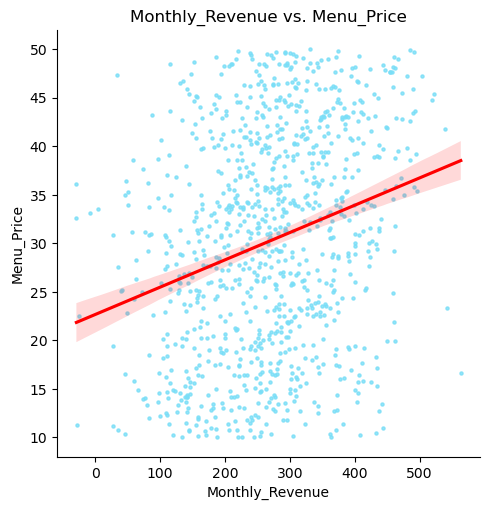

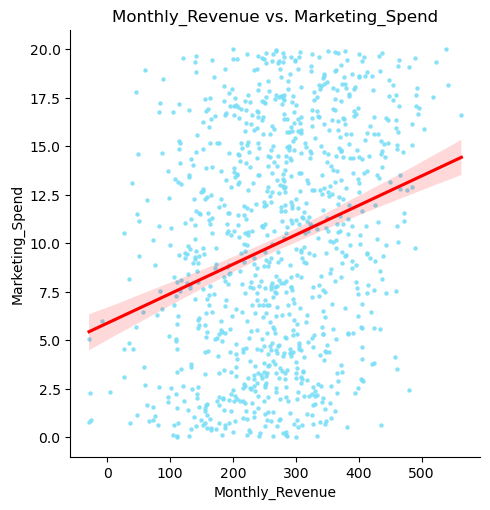

In [15]:
for col in ['Number_of_Customers', 'Menu_Price', 'Marketing_Spend']:
    scatter_with_fit(df, 'Monthly_Revenue', col)

## Step 4: Grouping Revenue by Categories

In [16]:
types = df.groupby(by='Cuisine_Type').Monthly_Revenue.agg(np.mean).reset_index()
proms = df.groupby(by='Promotions').Monthly_Revenue.agg(np.mean).reset_index()

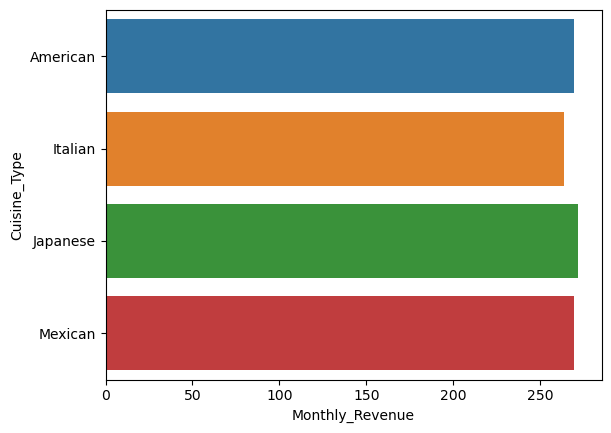

In [17]:
sns.barplot(data=types, x='Monthly_Revenue', y='Cuisine_Type')
plt.show()

In [18]:
types

,Cuisine_Type,Monthly_Revenue
0,American,269.604825
1,Italian,263.699862
2,Japanese,271.700186
3,Mexican,269.366082


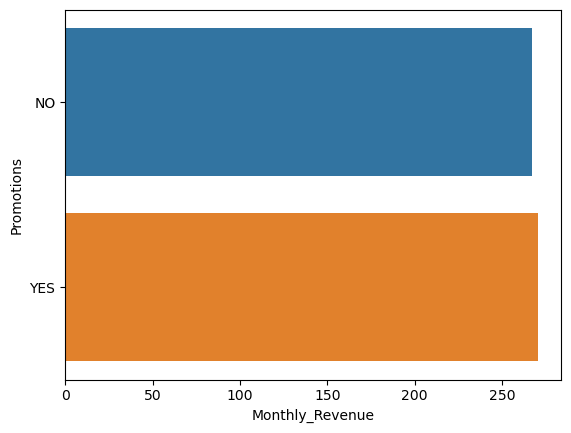

In [19]:
proms.iloc[0,0] = 'NO'
proms.iloc[1,0] = 'YES'
sns.barplot(data=proms, x='Monthly_Revenue', y='Promotions')
plt.show()

In [20]:
proms

,Promotions,Monthly_Revenue
0,NO,267.188084
1,YES,270.278805


In [33]:
# Percent difference in aggregated monthly revenue for the presence of a promotional campaign to establish the campaign's 
# worth

print('The percent difference in aggregated monthly restaurant revenue with the presence of a promotional campaign is', 
      ((proms['Monthly_Revenue'][1] / proms['Monthly_Revenue'][0]) - 1) * 100)

The percent difference in aggregated monthly restaurant revenue with the presence of a promotional campaign is 1.1567584291771071
